### Numpy 加速
Python 是一种相对较慢的编程语言，但是我们可以通过使用Numpy来加速Python的运算。Numpy是一个基于C语言的库，提供了许多高效的运算函数，例如矩阵运算和线性代数运算等。这些运算都基于C语言实现，因此速度非常快。

GP的性能瓶颈通常在于模型评估。因此，在这里，我们重点关注如何加速评估函数。其实很简单，将数据集转换为Numpy数组，然后使用Numpy函数来计算MSE即可。下面是一个例子。

In [1]:
import time

import numpy as np
from deap import base, creator, tools, gp


# 符号回归
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100) 
    
    # 评估生成的函数并计算MSE
    mse = np.mean((func(x) - x**2)**2)
    
    return (mse,)

# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


同时，我们还可以考虑将一些算子替换为Numpy函数。尽管这并不是非常重要，因为Numpy已经重载了许多运算符。

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
def random_int(): return random.randint(-1, 1)
pset.addEphemeralConstant("rand101", random_int)
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

现在，让我们来测试一下加速效果。

In [3]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
np_time=[]
for i in range(3):
    start=time.time()
    population = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end=time.time()
    print('time:',end-start)
    np_time.append(end-start)
    print(str(hof[0]))

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min	nevals	std    	avg 	gen	max	min	nevals	std    
0  	300   	2766.75	0  	153712	0  	300   	8877.46	4.11	0  	7  	2  	300   	1.74296
1  	274   	2488.01	1  	153712	0  	274   	8797.77	4.45	1  	13 	2  	274   	1.95299
2  	268   	3219.64	2  	153712	0  	268   	15082.5	4.52333	2  	11 	2  	268   	2.03047
3  	282   	3344.96	3  	157909	0  	282   	15152.3	4.69   	3  	15 	2  	282   	2.14023
4  	264   	3064.63	4  	153712	0  	264   	15213  	4.53333	4  	13 	2  	264   	1.86964
5  	277   	3434.63	5  	155827	0  	277   	17621.7	4.46667	5  	15 	2  	277   	1.96695
6  	281   	2816.65	6  	153712	0  	281   	17414.1	4.13667	6  	13 	2  	281   	1.87207
7  	281   	43118.7	7  	1.23323e+07	0  	281   	710861 	3.92667	7  	11 	3  	281   	1.71502
8  	287   	42426.8	8  	1.23323e+07

对比下面的原始评估函数，使用Numpy的加速效果还是非常明显的。

In [4]:
# 慢速评估
def evalSymbRegSlow(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 创建评估数据
    xs = [x/5.0 for x in range(-50, 51)]
    
    # 评估生成的函数并计算MSE
    mse = sum((func(x) - x**2)**2 for x in xs) / len(xs)
    
    return (mse,)

toolbox.register("evaluate", evalSymbRegSlow, pset=pset)

py_time=[]
for i in range(3):
    start=time.time()
    population = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end=time.time()
    print('time:',end-start)
    py_time.append(end-start)

   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min	nevals	std   	avg    	gen	max	min	nevals	std    
0  	300   	46421.7	0  	1.17166e+07	0  	300   	676811	4.09333	0  	7  	2  	300   	1.66872
1  	268   	2873.24	1  	153622     	0  	268   	12394.6	4.08   	1  	12 	2  	268   	1.65538
2  	280   	2332.44	2  	153622     	0  	280   	8874.81	4.35   	2  	11 	2  	280   	1.83144
3  	268   	3895.82	3  	159864     	0  	268   	17600.9	4.50333	3  	12 	2  	268   	1.77857
4  	273   	3744.34	4  	159864     	0  	273   	17733.1	4.60333	4  	17 	2  	273   	2.12116
5  	277   	44273.3	5  	1.17166e+07	0  	277   	675477 	4.20667	5  	15 	2  	277   	1.86117
6  	264   	5315.34	6  	155737     	0  	264   	26123.2	4.13333	6  	11 	3  	264   	1.76698
7  	273   	7673.51	7  	608247     	0  	273   	44427  	3.79333	

最后，我们可以使用seaborn绘制一个图来比较Numpy和Python的性能。可以看出，Numpy显著提高了速度。

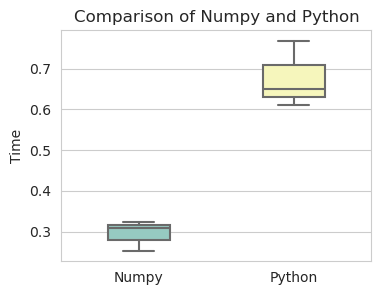

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
data = pd.DataFrame({'Category': ['Numpy'] * len(np_time) + ['Python'] * len(py_time),
                     'Time': np.concatenate([np_time, py_time])})


plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time',palette="Set3", width=0.4)
plt.title('Comparison of Numpy and Python')
plt.xlabel('')
plt.ylabel('Time')
plt.show()